In [10]:
import matplotlib.pyplot as plt
import os, json
import numpy as np
import pandas as pd
import seaborn as sns
import re

GEN_DFS = False # True if you need to read data from the json files, otherwise read dataframes from the csvs
WRITE_CSVS = False # True for overwriting csvs

In [11]:
datadir = "./results/"
search_files = [datadir + x for x in os.listdir(datadir) if "search" in x]
upload_files = [datadir + x for x in os.listdir(datadir) if "upload" in x]
gsi_search = [x for x in search_files if "gsi" in x]
weaviate_files = [datadir + x for x in os.listdir(datadir) if "weaviate" in x]
weaviate_search = [x for x in weaviate_files if "search" in x]
weaviate_upload = [x for x in weaviate_files if "upload" in x]
qdrant_files = [datadir + x for x in os.listdir(datadir) if "qdrant" in x]
qdrant_search = [x for x in qdrant_files if "search" in x]
qdrant_upload = [x for x in qdrant_files if "upload" in x]
hnsw_search = [x for x in search_files if "hnswlib" in x and "gxl" not in x]
hnsw_upload = [x for x in upload_files if "hnswlib" in x and "gxl" not in x]
gxl_search = [x for x in search_files if "gxl" in x]
gxl_upload = [x for x in upload_files if "gxl" in x]

## Results

In [12]:
def parse_weav_search(fname):
    # filename parsing
    tmp = fname.split('-')
    if tmp[1] == "gxl":
        if tmp[7].isnumeric():
            m, efc, dataset, dim = int(tmp[3]), int(tmp[5]), tmp[6], int(tmp[7])
        else:
            m, efc, dataset, dim = int(tmp[3]), int(tmp[5]), f"{tmp[6]}-{tmp[7]}", int(tmp[8])
    else:    
        if tmp[6].isnumeric():
            m, efc, dataset, dim = int(tmp[2]), int(tmp[4]), tmp[5], int(tmp[6])
        else:
            m, efc, dataset, dim = int(tmp[2]), int(tmp[4]), f"{tmp[5]}-{tmp[6]}", int(tmp[7])
    row = {'vdb': 'weaviate', 'm':m, 'efc': efc, 'dataset': dataset, 'dim': dim}

    # json file parse
    f = open(fname)
    tmp = json.load(f)
    row.update(tmp['params'].pop('vectorIndexConfig'))
    row.update(tmp['params'])
    row.update(tmp['results'])
    return row

In [13]:
def parse_gsi_search(fname):
    nbits, dim, dataset, m, efc, ef, new, nprobe, nprobe_rerank, hammingk = [None] * 10
    # filename parsing
    tmp = fname.split('-')
    if "new" in fname:
        new = True
    elif "nprobe" in fname:
        nprobe, nprobe_rerank, hammingk = tmp[3], tmp[5], tmp[7]
    # get nbits, dims, and dataset
    search_type = tmp[2]
    # get hnsw params if available
    if search_type == "hnsw":
        if "-m-" not in fname:
            # set default values
            m, efc, ef = 32, 100, 100
        else:
            # pop 'm' and 'ef' values
            m, efc = tmp.pop(4), tmp.pop(5)
            # remove 'm' and 'ef'
            tmp.pop(3), tmp.pop(3)
    # get dataset and nbits params
    for i, x in enumerate(tmp):
        if x.isnumeric():
            if not nbits:
                nbits = int(x)
            elif not dim:
                if (nprobe and i > 7) or not nprobe:
                    if tmp[i-1] == "image":
                        dataset = f"{tmp[i-2]}-{tmp[i-1]}"
                        if tmp[i+2][0].isnumeric():
                            dataset += f"-{tmp[i+2]}"
                        else:
                            dataset += "-10M"
                        dim = int(tmp[i])
                    else:
                        dataset = f"{tmp[i-1]}"
                        dim = int(tmp[i])

    row = {'vdb': 'gsi', 'search_type': search_type, 'nbits': nbits, 'dataset': dataset, 'dim': dim, 
           'm':m, 'efc': efc, 'ef': ef, 'new': new, 'nprobe': nprobe, 'nprobe_rerank': nprobe_rerank, 'hammingk': hammingk}
    # json file parse
    f = open(fname)
    tmp = json.load(f)
    # add json file data to row
    if '-m-' in fname:
        row.update(tmp['params'].pop('vectorIndexConfig'))
        row.update(tmp['params'])
    row.update(tmp['results'])
    return row

In [14]:
def parse_qdrant_search(fname):
    # filename parsing
    tmp = fname.split('-')
    if "rps" in fname or "mmap" in fname: 
        mode = tmp.pop(1)
    else: 
        mode = 'default'
    if tmp[6].isnumeric():
        m, efc, dataset, dim = int(tmp[2]), int(tmp[4]), tmp[5], int(tmp[6])
    else:
        if tmp[9][0].isnumeric():
            m, efc, dataset, dim = int(tmp[2]), int(tmp[4]), f"{tmp[5]}-{tmp[6]}-{tmp[9]}", int(tmp[7])            
        else:
            m, efc, dataset, dim = int(tmp[2]), int(tmp[4]), f"{tmp[5]}-{tmp[6]}-10M", int(tmp[7])
    row = {'vdb': 'qdrant', 'm':m, 'efc': efc, 'dataset': dataset, 'dim': dim, 'mode': mode}

    # json file parse
    f = open(fname)
    tmp = json.load(f)
    row.update(tmp['params'].pop('search_params'))
    row.update(tmp['params'])
    row.update(tmp['results'])
    return row

In [15]:
def gen_gsi():# create GSI search results dataframe
    columns = ['vdb', 'search_type', 'nbits', 'dataset', 'dim', 'm', 'efc', 'ef', 'nprobe', 'nprobe_rerank', 'hammingk', 'new', 'total_time', 'mean_time',\
                'mean_precisions', 'std_time', 'min_time', 'max_time', 'rps', 'p95_time', 'p99_time',\
                'precisions', 'latencies']
    gsi_df = pd.DataFrame(columns=columns)
    for fname in gsi_search:
        gsi_df.loc[len(gsi_df), :] = parse_gsi_search(fname)
    gsi_df.fillna(np.nan)
    gsi_df = gsi_df.astype({'m': float, 'efc': float, 'ef': float, 'dim': int, 'mean_precisions': float, 'mean_time': float})
    gsi_df = gsi_df.astype({'m': 'Int64', 'efc': 'Int64', 'ef': 'Int64'})
    gsi_df = gsi_df.sort_values(by=['search_type', 'dataset', 'dim', 'nbits']).reset_index(drop=True)
    gsi_df.new = gsi_df.new.fillna(False)
    gsi_df = gsi_df.astype({'new': 'Int64', 'nprobe': 'Int64', 'nprobe_rerank': 'Int64', 'hammingk': 'Int64'})
    gsi_df.new[9] = 2
    return gsi_df

In [16]:
def gen_weav_docker():# create weaviate search results dataframe
    columns = ['vdb', 'm', 'efc', 'ef', 'dataset', 'dim', 'parallel', 'total_time', 'mean_time',\
                'mean_precisions', 'std_time', 'min_time', 'max_time', 'rps', 'p95_time', 'p99_time',\
                'precisions', 'latencies']
    weav_df = pd.DataFrame(columns=columns)
    for fname in weaviate_search:
        row = parse_weav_search(fname)
        weav_df.loc[len(weav_df)] = row
    weav_df = weav_df.sort_values(by=['m', 'efc', 'dim', 'ef']).reset_index(drop=True)
    weav_df.parallel.fillna(0, inplace=True)
    weav_df_docker = weav_df.copy()
    return weav_df_docker

In [17]:
def gen_qdrant():# create qdrant search results dataframe
    columns = ['vdb', 'm', 'efc', 'hnsw_ef', 'dataset', 'dim', 'parallel', 'total_time', 'mean_time',\
                'mean_precisions', 'std_time', 'min_time', 'max_time', 'rps', 'p95_time', 'p99_time',\
                'precisions', 'latencies']
    qdrant_df = pd.DataFrame(columns=columns)
    for fname in qdrant_search:
        qdrant_df.loc[len(qdrant_df)] = parse_qdrant_search(fname)
    qdrant_df = qdrant_df.sort_values(by=['m', 'efc', 'dim', 'hnsw_ef']).reset_index(drop=True)
    return qdrant_df

In [18]:
def gen_hnsw():# create hnswlib search results dataframe
    hnsw_df = pd.DataFrame(columns=parse_weav_search(hnsw_search[0]).keys())
    for fname in hnsw_search:
        row = parse_weav_search(fname)
        hnsw_df.loc[len(hnsw_df), :] = row
    hnsw_df.vdb = 'hnswlib'
    hnsw_df = hnsw_df.sort_values(['m', 'efc', 'ef', 'parallel']).reset_index(drop=True)
    return hnsw_df
def gen_gxl():# create gxl search results dataframe
    gxl_df = pd.DataFrame(columns=parse_weav_search(gxl_search[0]).keys())
    for fname in gxl_search:
        row = parse_weav_search(fname)
        gxl_df.loc[len(gxl_df), :] = row
    gxl_df.vdb = 'hnswlib_gxl'
    gxl_df = gxl_df.sort_values(['m', 'efc', 'ef']).reset_index(drop=True)
    return gxl_df

In [20]:
if GEN_DFS:
    gsi_df = gen_gsi()
    weav_df_docker = gen_weav_docker()
    qdrant_df = gen_qdrant()
    hnsw_df = gen_hnsw()
    gxl_df = gen_gxl()
else:
    qdrant_df = pd.read_csv('results/qdrant-df.csv')
    weav_df_docker = pd.read_csv('results/weaviate-df.csv')
    gsi_df = pd.read_csv('results/gsi-df.csv')
    hnsw_df = pd.read_csv('results/hnswlib-df.csv')
    gxl_df = pd.read_csv('results/gxl-df.csv')

if WRITE_CSVS:
    qdrant_df.to_csv('results/qdrant-df.csv', index=False)
    weav_df_docker.to_csv('results/weaviate-df.csv', index=False)
    gsi_df.to_csv('results/gsi-df.csv', index=False)
    hnsw_df.to_csv('results/hnswlib-df.csv', index=False)
    gxl_df.to_csv('results/gxl-df.csv', index=False)

## Seaborn plots

In [21]:
parallels = [1, 0]
dim = 96
size = "10M"
nprobes = [250, 850]

qdrant_copy = qdrant_df.copy()
qdrant_copy = qdrant_copy[(qdrant_copy.dim == dim) & (qdrant_copy.parallel.isin(parallels)) & (qdrant_copy.dataset.str.contains(size))]
weav_copy = weav_df_docker.copy()
weav_copy = weav_copy[(weav_copy.dim == dim) & (weav_copy.parallel.isin(parallels))]
hnsw_copy = hnsw_df.copy()
hnsw_copy = hnsw_copy[(hnsw_copy.dim == dim) & (hnsw_copy.parallel.isin(parallels))]
gsi_copy = gsi_df.copy()
gsi_nprobe_copy = gsi_copy[(gsi_copy.dim == dim) & (gsi_copy.nprobe.isin(nprobes)) & (gsi_copy.dataset.str.contains(size))]
gsi_fvs_copy = gsi_copy[(gsi_copy.dim == dim) & (gsi_copy.dataset.str.contains(size) & (gsi_copy.nprobe.isna()) & (gsi_copy.new == 0))]
gxl_copy = gxl_df.copy()
gxl_copy = gxl_copy[(gxl_copy.dim == dim) & (gxl_copy.parallel.isin(parallels))]

In [22]:
gb = weav_copy.groupby(['efc', 'm', 'ef']).agg({'mean_precisions': 'mean', 'mean_time': 'mean'})
weav_copy = gb.reset_index()
gb = qdrant_copy.groupby(['efc', 'm', 'hnsw_ef']).agg({'mean_precisions': 'mean', 'mean_time': 'mean'})
qdrant_copy = gb.reset_index()
gb = hnsw_copy.groupby(['efc', 'm', 'ef']).agg({'mean_precisions': 'mean', 'mean_time': 'mean'})
hnsw_copy = gb.reset_index()
gb = gxl_copy.groupby(['efc', 'm', 'ef']).agg({'mean_precisions': 'mean', 'mean_time': 'mean'})
gxl_copy = gxl_copy.reset_index()

/tmp/ipykernel_9617/3783804766.py:56: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


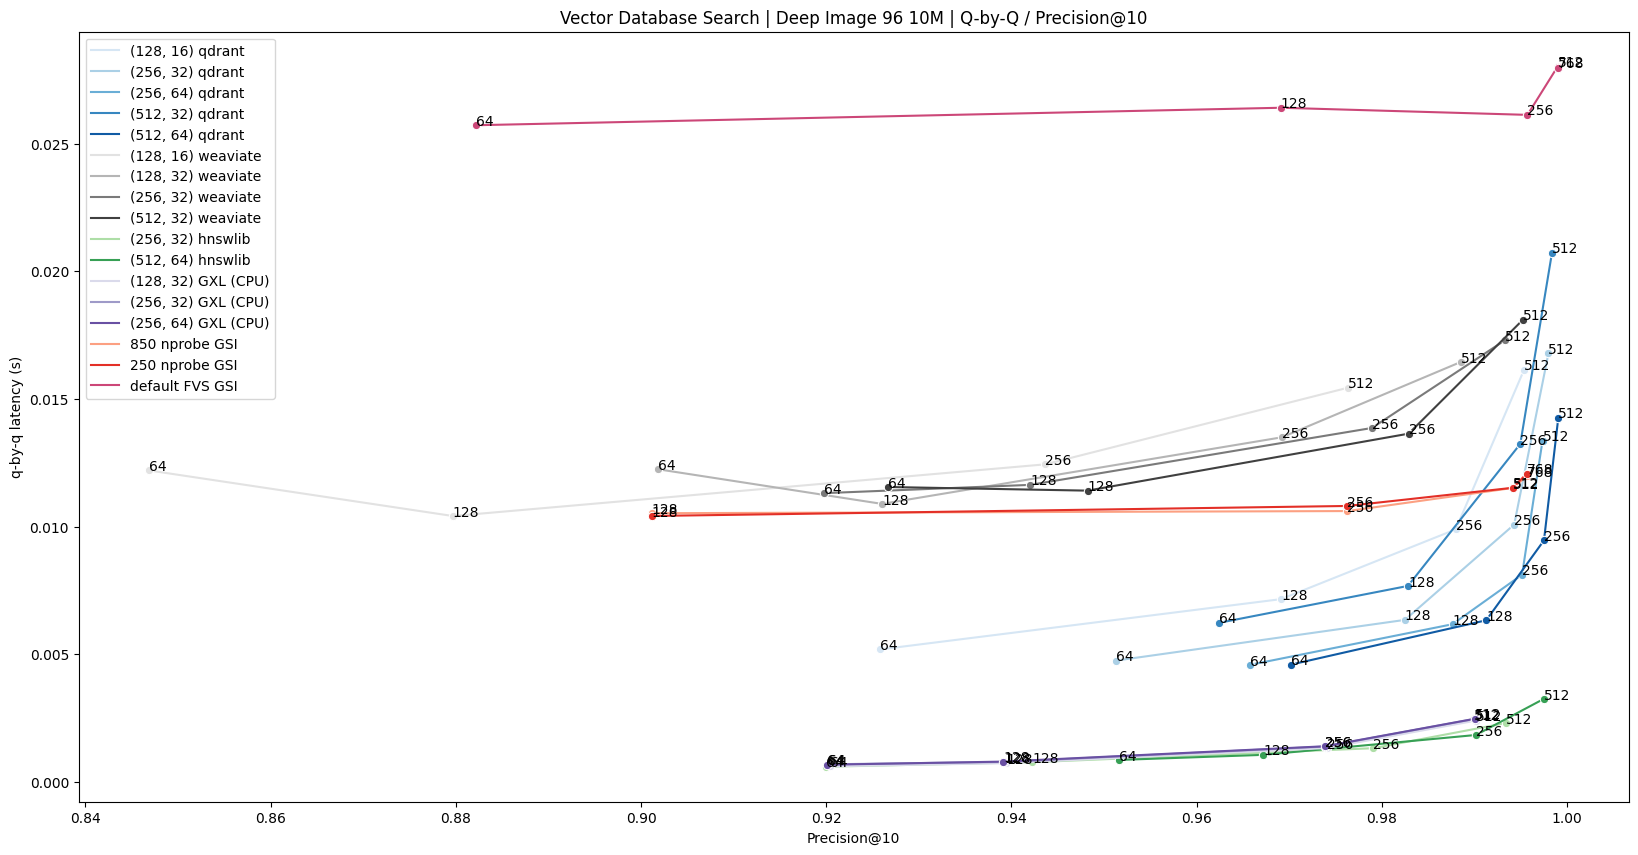

In [39]:
fig, ax = plt.subplots(figsize=(20,10))

qdrant_configs = qdrant_copy.groupby(["efc", "m"]).count().index.to_list()
weav_configs = weav_copy.groupby(["efc", "m"]).count().index.to_list()
hnsw_configs = hnsw_copy.groupby(["efc", "m"]).count().index.to_list()
gxl_configs = gxl_copy.groupby(["efc", "m"]).count().index.to_list()
gsi_configs = gsi_nprobe_copy.groupby("nprobe").count().index.to_list()

ax.set_title(f"Vector Database Search | Deep Image 96 {size} | Q-by-Q / Precision@10")
ax.set_xlabel("Precision@10")
ax.set_ylabel("q-by-q latency (s)")

palette = sns.color_palette("Blues", len(qdrant_configs))
sns.lineplot(data=qdrant_copy, x="mean_precisions", y="mean_time", hue=qdrant_copy[["efc", "m"]].apply(tuple, axis=1), marker="o", palette=palette)
for ef, x, y in zip(qdrant_copy.hnsw_ef, qdrant_copy.mean_precisions, qdrant_copy.mean_time):
    plt.annotate(ef, (x, y))

palette = sns.color_palette("Greys", len(weav_configs))
sns.lineplot(data=weav_copy, x="mean_precisions", y="mean_time", hue=weav_copy[["efc", "m"]].apply(tuple, axis=1), marker="o", palette=palette)
for ef, x, y in zip(weav_copy.ef, weav_copy.mean_precisions, weav_copy.mean_time):
    plt.annotate(ef, (x, y))
    
palette = sns.color_palette("Greens", len(hnsw_configs))
sns.lineplot(data=hnsw_copy, x="mean_precisions", y="mean_time", hue=hnsw_copy[["efc", "m"]].apply(tuple, axis=1), marker="o", palette=palette)
for ef, x, y in zip(hnsw_copy.ef, hnsw_copy.mean_precisions, hnsw_copy.mean_time):
    plt.annotate(ef, (x,y))
    
palette = sns.color_palette("Purples", len(gxl_configs))
sns.lineplot(data=gxl_copy, x="mean_precisions", y="mean_time", hue=gxl_copy[["efc", "m"]].apply(tuple, axis=1), marker="o", palette=palette)
for ef, x, y in zip(gxl_copy.ef, gxl_copy.mean_precisions, gxl_copy.mean_time):
    plt.annotate(ef, (x,y))

palette = sns.color_palette("Reds", len(gsi_configs))
sns.lineplot(data=gsi_nprobe_copy, x="mean_precisions", y="mean_time", hue=gsi_nprobe_copy[["nprobe"]].apply(tuple, axis=1), marker="o", palette=palette)
for _, row in gsi_nprobe_copy.iterrows():
    plt.annotate(row.nbits, (row.mean_precisions, row.mean_time))

palette = sns.color_palette("plasma", 1)
sns.lineplot(data=gsi_fvs_copy, x="mean_precisions", y="mean_time", hue="dataset", marker="o", palette=palette)
for _, row in gsi_fvs_copy.iterrows():
    plt.annotate(row.nbits, (row.mean_precisions, row.mean_time))

leg = ax.legend(loc='upper left')
curr = 0
[x.set_text(x.get_text() + ' qdrant') for x in leg.get_texts()[:len(qdrant_configs)]]
curr += len(qdrant_configs)
[x.set_text(x.get_text() + ' weaviate') for x in leg.get_texts()[curr:curr + len(weav_configs)]]
curr += len(weav_configs)
[x.set_text(x.get_text() + ' hnswlib') for x in leg.get_texts()[curr:curr + len(hnsw_configs)]]
curr += len(hnsw_configs)
[x.set_text(x.get_text() + ' GXL (CPU)') for x in leg.get_texts()[curr:curr + len(gxl_configs)]]
curr += len(gxl_configs)
[x.set_text(x.get_text()[1:4] + ' nprobe GSI') for x in leg.get_texts()[curr:curr + len(gsi_configs)]]
[x.set_text('default FVS GSI') for x in leg.get_texts()[-1:]]

fig.show()

## Upload

In [14]:
gxlu = pd.read_json(gxl_upload[0])
row = {}
row.update(gxlu['params']['vectorIndexConfig'])
row.update(gxlu.results[~gxlu.results.isna()].to_dict())
row.pop('ef')
row['dataset'] = None
gxlu = pd.DataFrame(columns=row.keys())
for path in [x for x in gxl_upload if "deep-image" in x]:
    tmp = pd.read_json(path)
    row = {}
    row.update(tmp['params']['vectorIndexConfig'])
    row.update(tmp.results[~tmp.results.isna()].to_dict())
    row.pop('ef')
    row['dataset'] = path.split('-')[6]
    gxlu.loc[len(gxlu), :] = row
gxlu.reset_index(drop=True, inplace=True)
gxlu.index = ['gxl\n' + str(x) for x in gxlu.groupby(['maxConnections', 'efConstruction']).count().index.to_list()]
gxlu.drop(['maxConnections', 'efConstruction'], axis = 1, inplace=True)
gxlu['total_time'] = gxlu[['cen_gen', 'knn_gen', 'knn_sym', 'idx_gen']].sum(axis=1)

In [15]:
qdrantu = pd.read_json(qdrant_upload[0])
row = {}
row.update(qdrantu['params']['hnsw_config'])
row.update(qdrantu['results'][~qdrantu['results'].isna()].to_dict())
row.pop('post_upload')
row['dataset'] = None
qdrantu = pd.DataFrame(columns=row.keys())
for path in [x for x in qdrant_upload if "deep-image" in x]:
    tmp = pd.read_json(path)
    row = {}
    row.update(tmp['params']['hnsw_config'])
    row.update(tmp['results'][~tmp['results'].isna()].to_dict())
    row.pop('post_upload')
    tmp = path.split('-')[5:10]
    if tmp[-1][:-1].isnumeric():
        row['dataset'] = tmp[-1]
    else:
        row['dataset'] = '10M'
    qdrantu.loc[len(qdrantu), :] = row

gb_cols = ['ef_construct', 'm', 'dataset']
tmp = qdrantu.groupby(gb_cols).count().index.to_list()
qdrantu.index = ['qdrant\n' + str(x) for x in tmp]
qdrantu.drop(gb_cols, axis = 1, inplace=True)

In [16]:
hnswu = pd.read_json(hnsw_upload[0])
row = {}
row.update(hnswu['params']['vectorIndexConfig'])
row.update(hnswu['results'][~hnswu['results'].isna()].to_dict())
row.pop('post_upload')
hnswu = pd.DataFrame(columns=row.keys())
for path in [x for x in hnsw_upload if "deep-image" in x]:
    tmp = pd.read_json(path)
    row = {}
    row.update(tmp['params']['vectorIndexConfig'])
    row.update(tmp['results'][~tmp['results'].isna()].to_dict())
    row['dataset'] = path.split('-')[5]
    hnswu.loc[len(hnswu), :] = row
hnswu.index = ['hnsw\n' + str(x) for x in hnswu.groupby(['efConstruction', 'maxConnections']).count().index.to_list()]
hnswu.drop(['maxConnections', 'efConstruction'], axis=1, inplace=True)

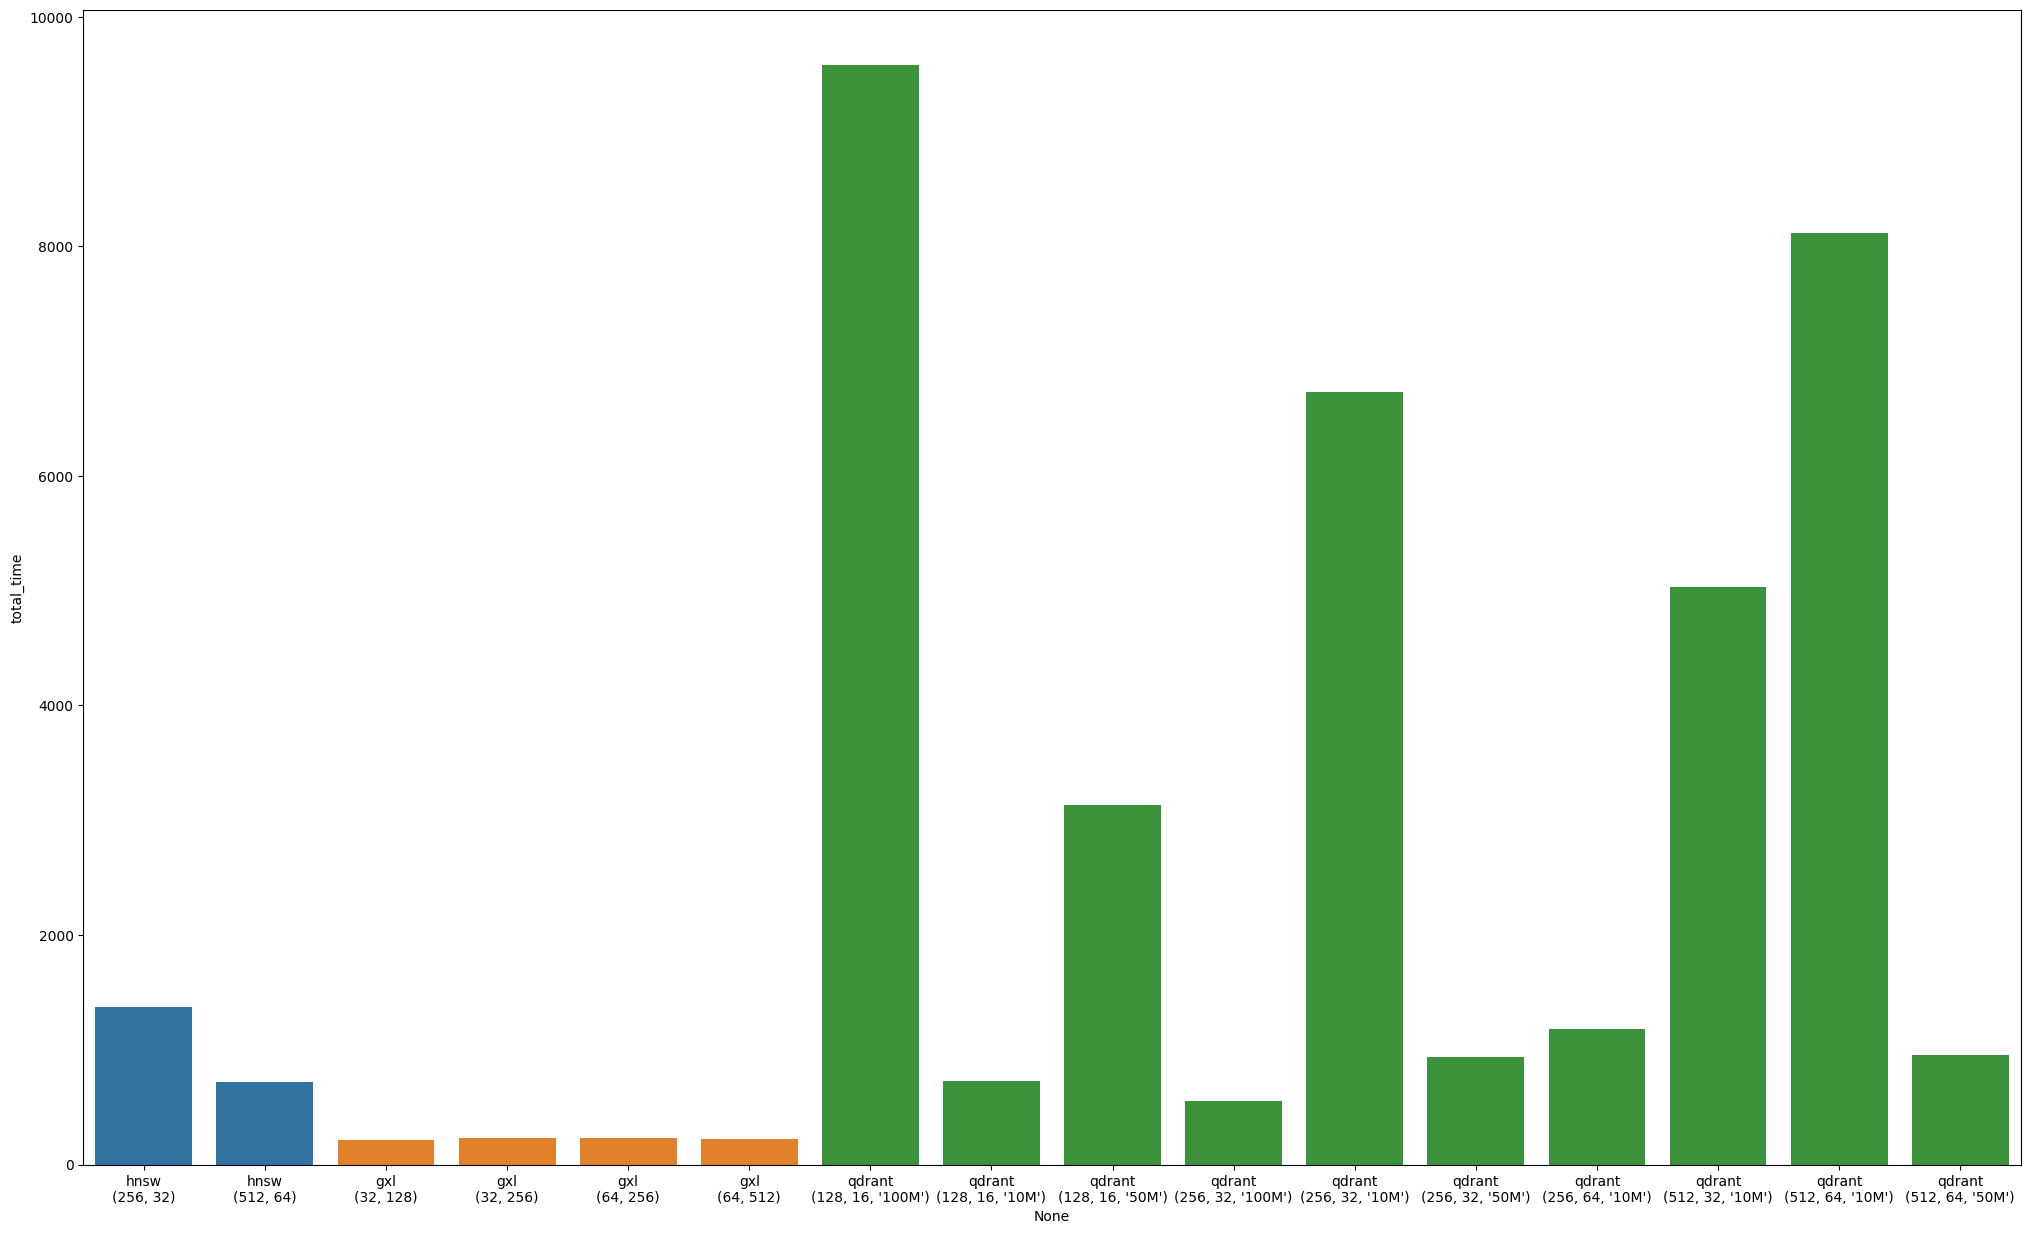

In [17]:
fig, ax = plt.subplots(figsize=(25,15))
sns.barplot(x=hnswu.index, y=hnswu.total_time)
sns.barplot(x=gxlu.index, y=gxlu.total_time)
sns.barplot(x=qdrantu.index, y=qdrantu.total_time)
fig.show()

## Search Beyond 10M

In [20]:
keep = ["10M", "50M", "100M"]
weav_files = [x for x in os.listdir("results") if "algodirect" in x]
rows = []
topk = 10
# 10M
for path in weav_files:
    split = re.split(r'_|-', path[:-4])
    size, ef = split[4], int(split[6])
    if size not in keep:
        continue
    path = os.path.join("results", path)
    tmp = pd.read_csv(path)
    tmp['inds'] = tmp['inds'].apply(lambda x: list(map(int, x.split("-"))))
    gt = np.load(f"data/deep-{size}-gt-1000.npy")
    precisions = []
    for i in range(tmp.shape[0]):
        precisions.append(len(np.intersect1d(gt[i][:topk], tmp.inds[i])) / topk)

    mean_precisions = np.mean(precisions)
    mean_time = np.mean(tmp.search_time)
    rows.append({'vdb': 'weaviate','size': size, 'm':64, 'efc': 64, 'ef': ef, 'mean_precisions': mean_precisions, 'mean_time': mean_time})
    
weav_df = pd.DataFrame(rows)

In [21]:
size = "100M"

# qdrant configs
parallel = 1
m, efc = 16, 128
qdrant_copy = qdrant_df[(qdrant_df.parallel == 1) & (qdrant_df.efc == efc) & (qdrant_df.m == m) & (qdrant_df.dataset.str.contains(size))]
# gsi configs
nprobe = 250
gsi_copy = gsi_df[(gsi_df.dataset.str.contains(size)) & (gsi_df.nprobe == nprobe)].reset_index(drop=True)
# weaviate AD configs
weav_copy = weav_df[(weav_df["size"] == size)].sort_values('ef').reset_index(drop=True)
# weaviate native configs
weav_docker_copy = weav_df_docker[(weav_df_docker["dim"] == 96) & (weav_df_docker["efc"] == efc) & (weav_df_docker.m == m)\
                                & (weav_df_docker["parallel"] == parallel)].sort_values('ef').reset_index(drop=True)
# qdrant configs
qdrant_copy = qdrant_df[(qdrant_df.parallel == 1) & (qdrant_df.efc == efc) & (qdrant_df.m == m) & (qdrant_df.dataset.str.contains(size))].reset_index(drop=True)

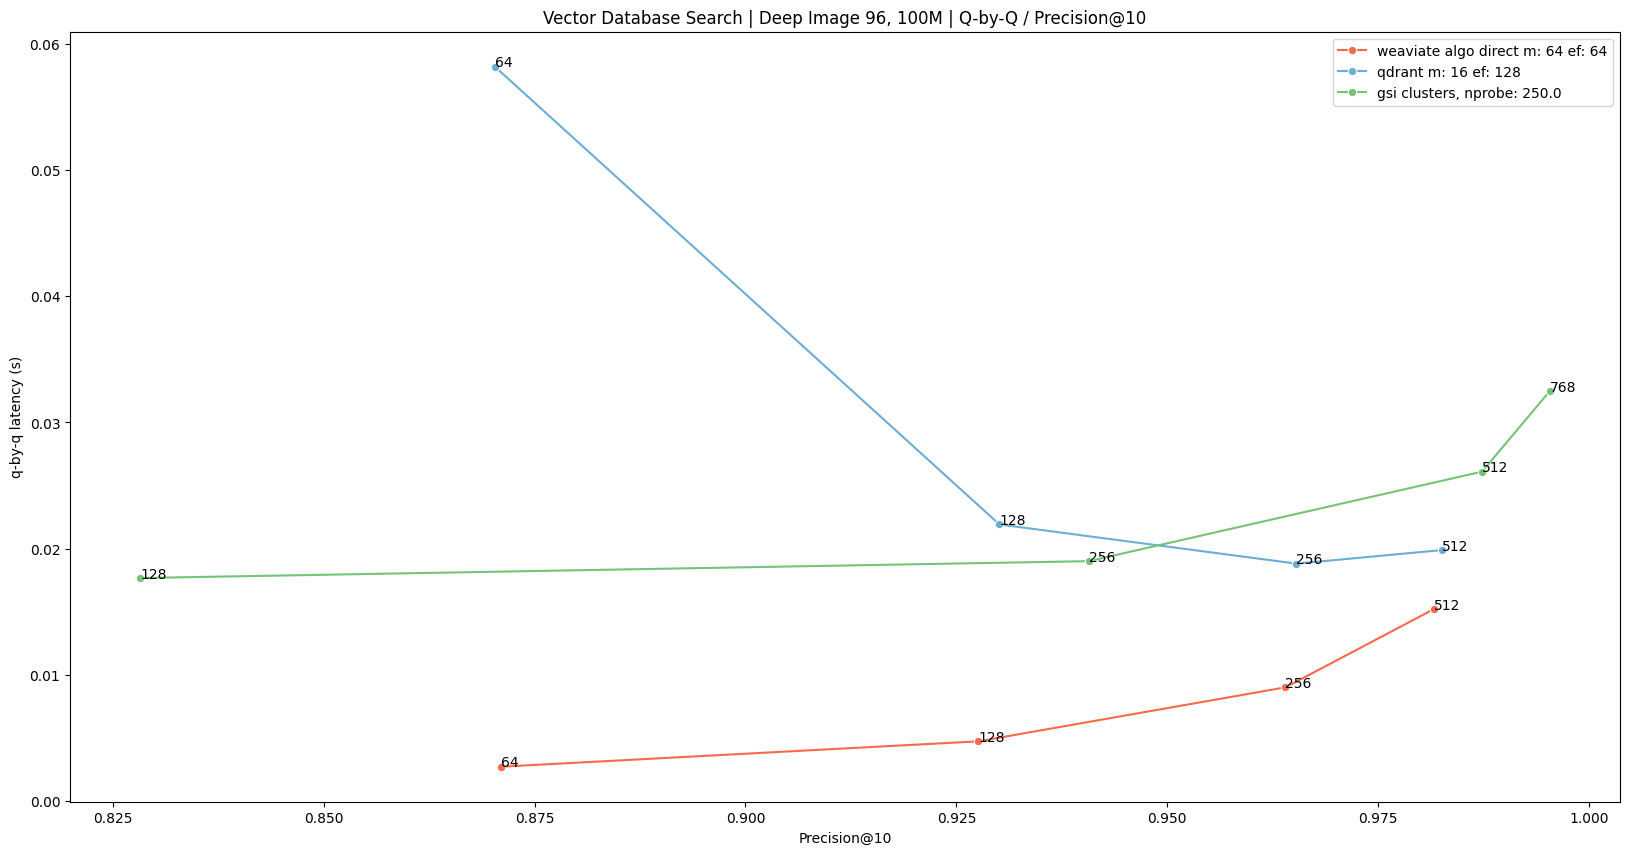

In [22]:
fig, ax = plt.subplots(figsize=(20,10))

# weaviate lines
palette = sns.color_palette('Reds', 1)
sns.lineplot(data = weav_copy, x = "mean_precisions", y = "mean_time", hue=weav_copy["size"], marker="o", palette=palette)
for _, row in weav_copy.iterrows():
    plt.annotate(row["ef"], (row["mean_precisions"], row["mean_time"]))

# qdrant lines
palette = sns.color_palette('Blues', 1)
sns.lineplot(data=qdrant_copy, x="mean_precisions", y="mean_time", hue=qdrant_copy["dataset"].apply(lambda x: x[11:]), marker="o", palette=palette)
for _, row in qdrant_copy.iterrows():
    plt.annotate(row["hnsw_ef"], (row["mean_precisions"], row["mean_time"]))

palette = sns.color_palette('Greens', 1)
sns.lineplot(gsi_copy, x="mean_precisions", y="mean_time", hue=gsi_copy.dataset.apply(lambda x: x[11:]), marker="o", palette=palette)
for _, row in gsi_copy.iterrows():
    plt.annotate(row["nbits"], (row["mean_precisions"], row["mean_time"]))

# palette = sns.color_palette("Purples", 1)
# sns.lineplot(weav_docker_copy, x="mean_precisions", y="mean_time", hue=weav_docker_copy.dataset, marker="o", palette=palette)
# for _, row in weav_docker_copy.iterrows():
    # plt.annotate(row.ef, (row.mean_precisions, row.mean_time))

leg = ax.legend()
leg.get_texts()[0].set_text(f"weaviate algo direct m: {weav_copy.m.unique()[0]} ef: {weav_copy.efc.unique()[0]}")
leg.get_texts()[1].set_text(f"qdrant m: {qdrant_copy.m[0]} ef: {qdrant_copy.efc[0]}")
leg.get_texts()[2].set_text(f"gsi clusters, nprobe: {gsi_copy.nprobe[0]}") 
# leg.get_texts()[3].set_text(f"weaviate native m: {weav_docker_copy.m[0]} ef: {weav_docker_copy.efc[0]}")

ax.set_title(f"Vector Database Search | Deep Image 96, {size} | Q-by-Q / Precision@10")
ax.set_xlabel("Precision@10")
ax.set_ylabel("q-by-q latency (s)")

fig.show()

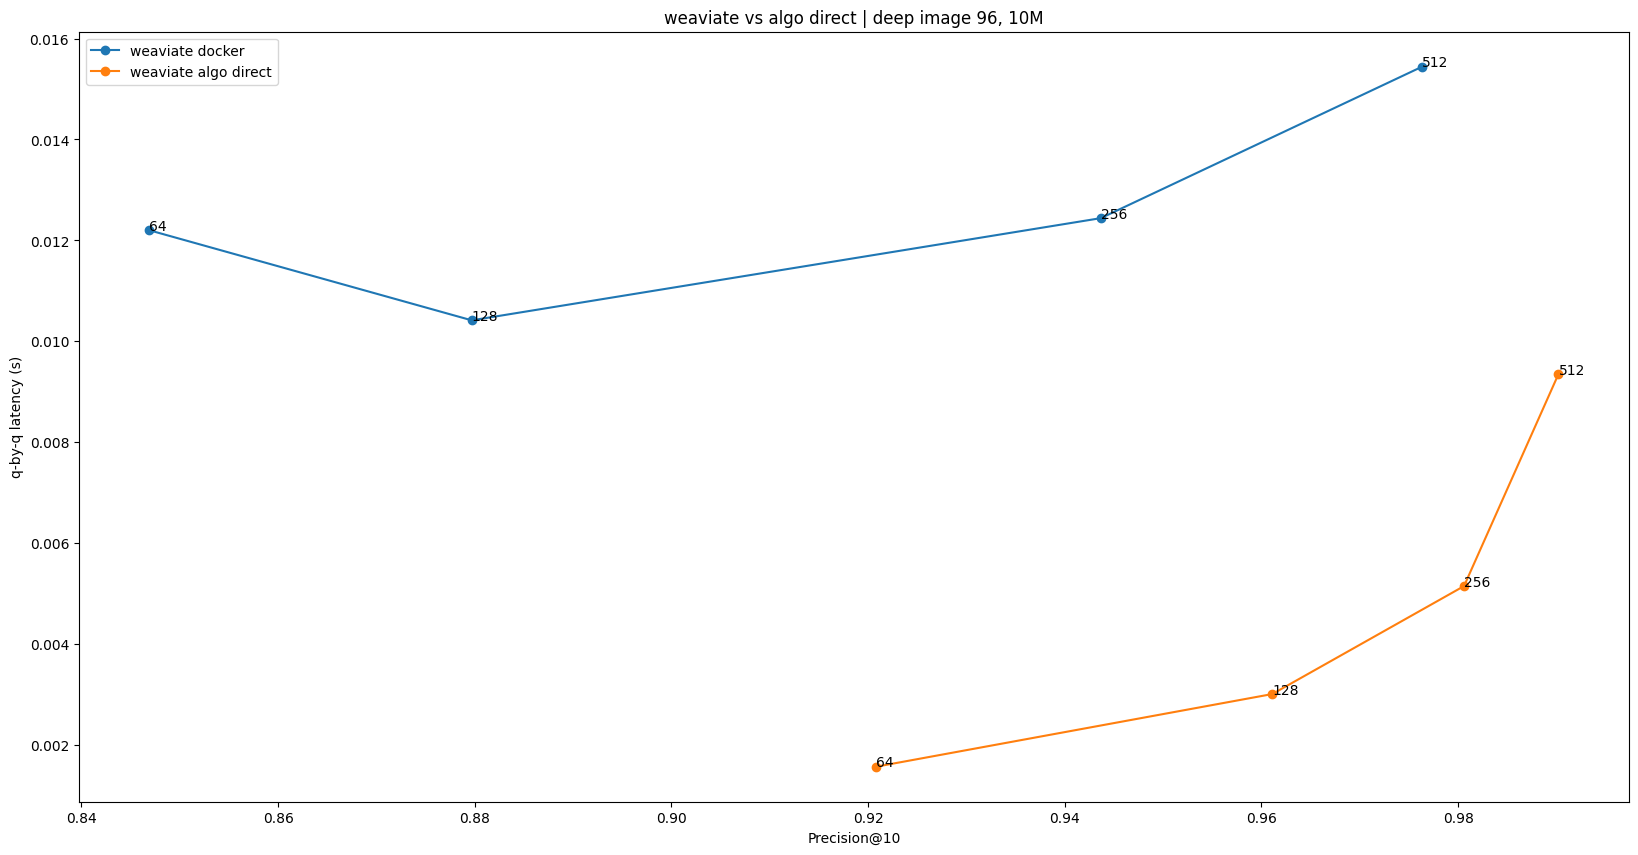

In [23]:
weav_copy = weav_df[(weav_df["size"] == "10M")].sort_values('ef').reset_index(drop=True)


fig, ax = plt.subplots(figsize=(20,10))
weav_df_docker_copy = weav_df_docker[(weav_df_docker.dataset.str.contains("deep-image")) & (weav_df_docker.parallel == 1) & (weav_df_docker.m == 16)].sort_values('ef')

ax.plot(weav_df_docker_copy['mean_precisions'], weav_df_docker_copy['mean_time'], marker="o")
for _, row in weav_df_docker_copy.iterrows():
    ax.annotate(row.ef, (row.mean_precisions, row.mean_time))

ax.plot(weav_copy['mean_precisions'], weav_copy['mean_time'], marker="o")
for _, row in weav_copy.iterrows():
    ax.annotate(row.ef, (row.mean_precisions, row.mean_time))

ax.legend(['weaviate docker', 'weaviate algo direct'], loc='upper left')
ax.set_title(("weaviate vs algo direct | deep image 96, 10M"))
ax.set_xlabel("Precision@10")
ax.set_ylabel("q-by-q latency (s)")
fig.show()